<a href="https://colab.research.google.com/github/seongcho1/mnetest/blob/main/mne001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://mne.tools/1.0/auto_tutorials/intro/10_overview.html#sphx-glr-auto-tutorials-intro-10-overview-py

In [4]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 76.1 MB/s eta 0:00:00


In [5]:
import os
import numpy as np
import mne

In [64]:
from mne import Epochs, pick_types, create_info, events_from_annotations
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci

event_id = dict(hands=2, feet=3)  # motor imagery: hands vs feet
subject = 1
runs = [6, 10, 14]
#runs = [1, ]
#runs = [6,]

raw = mne.io.read_raw_edf(
    mne.datasets.eegbci.load_data(subject=subject, runs=runs)[0], preload=True)

mne.datasets.eegbci.standardize(raw)  # set channel names
montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(montage)
#raw.filter(l_freq=1., h_freq=None)

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


<RawEDF | S001R06.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>

In [65]:
print(raw)
print(raw.info)

<RawEDF | S001R06.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)


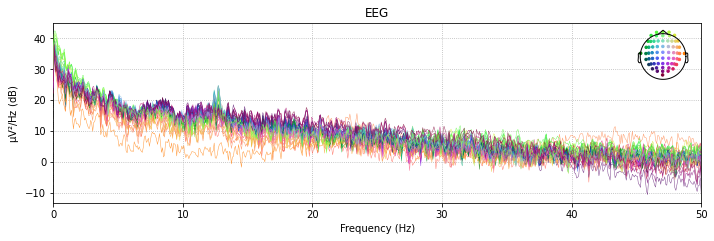

/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


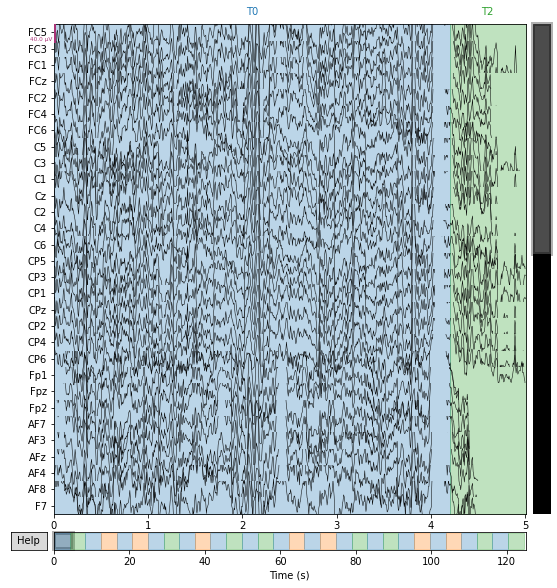

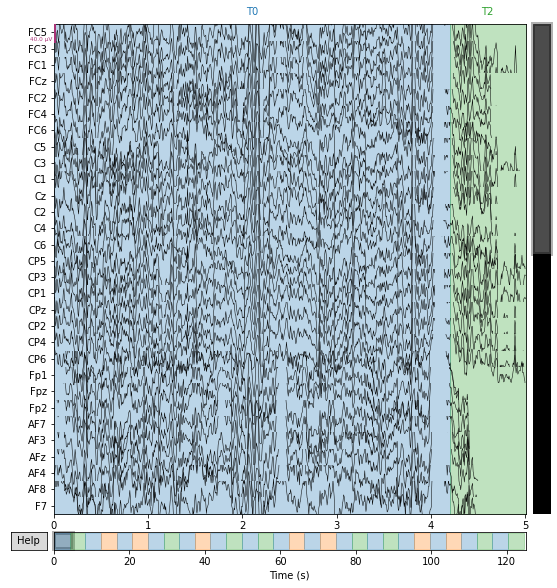

In [66]:
raw.plot_psd(fmax=50)
raw.plot(duration=5, n_channels=30)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components


<ipython-input-67-aa77dd0b6761>:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.9s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated


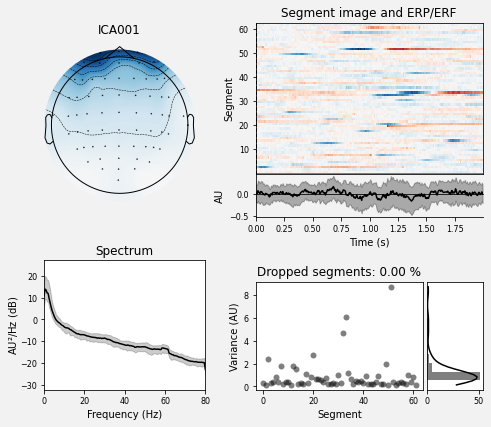

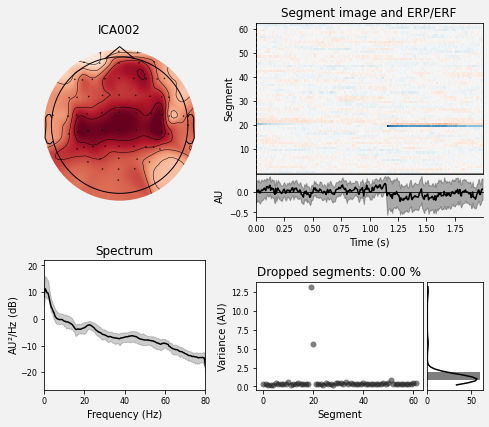

[<Figure size 504x432 with 6 Axes>, <Figure size 504x432 with 6 Axes>]

In [67]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


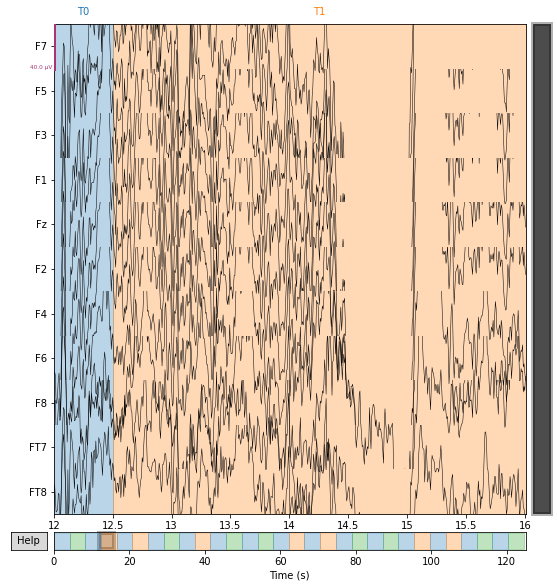

/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


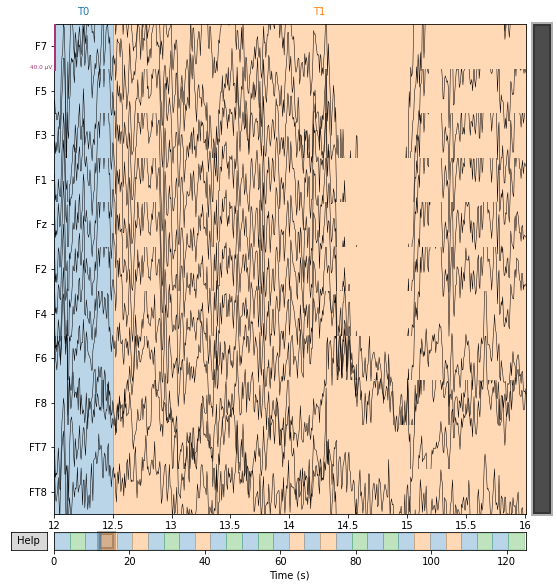

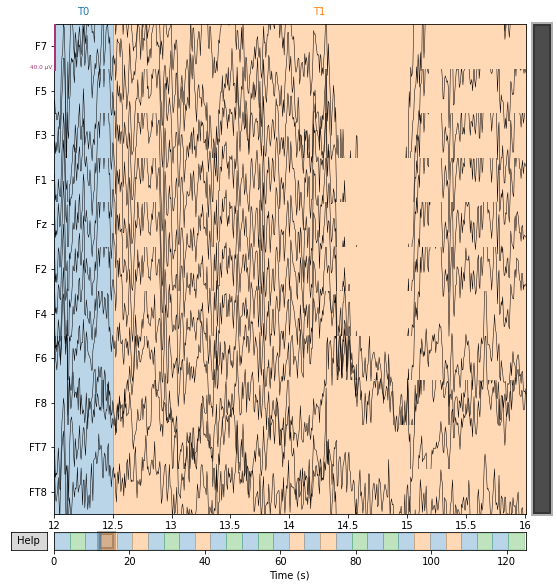

In [68]:
orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)

chs = raw.info.ch_names
chs = chs[29:40]

chan_idxs = [raw.ch_names.index(ch) for ch in chs]
orig_raw.plot(order=chan_idxs, start=12, duration=4)
raw.plot(order=chan_idxs, start=12, duration=4)


In [69]:
events, _ = events_from_annotations(raw)
print(events[:5])  # show the first 5

Used Annotations descriptions: ['T0', 'T1', 'T2']
[[   0    0    1]
 [ 672    0    3]
 [1328    0    1]
 [2000    0    2]
 [2656    0    1]]


In [70]:
event_dict = {'T0': 0, 'T1': 1, 'T2': 2 }

In [71]:
reject_criteria = dict(mag=4000e-15,     # 4000 fT
                       grad=4000e-13,    # 4000 fT/cm
                       eeg=150e-6,       # 150 µV
                       eog=250e-6)       # 250 µV

In [73]:
tmin, tmax = -1., 4.
event_id = dict(hands=2, feet=3)

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)
epochs.crop(tmin=1., tmax=None)
labels = epochs.events[:, 2] - 2

Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 801 original time points ...
0 bad epochs dropped


In [77]:
print(epochs.info)
print(labels)

<Info | 8 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>
[1 0 0 1 0 1 1 0 0 1 1 0 0 1 1]


In [83]:
hands_epochs = epochs['hands']
feet_epochs = epochs['feet']

Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated


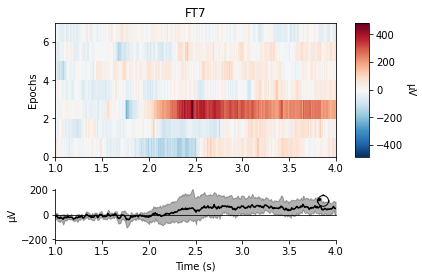

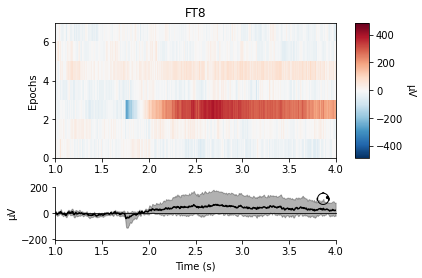

[<Figure size 432x288 with 4 Axes>, <Figure size 432x288 with 4 Axes>]

In [85]:
hands_epochs.plot_image(picks=['FT7', 'FT8'])

No baseline correction applied


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


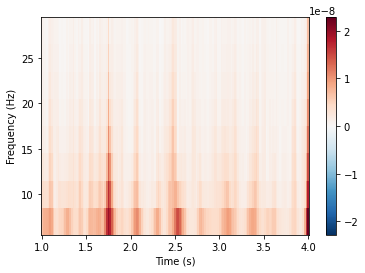

[<Figure size 432x288 with 2 Axes>]

In [86]:
frequencies = np.arange(7, 30, 3)
power = mne.time_frequency.tfr_morlet(hands_epochs, n_cycles=2, return_itc=False,
                                      freqs=frequencies, decim=3)
power.plot(['FT7'])

combining channels using "gfp"
combining channels using "gfp"


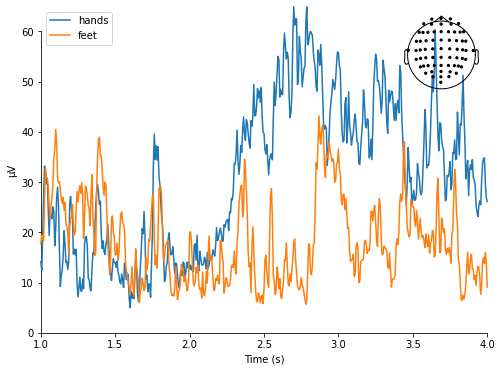

[<Figure size 576x432 with 2 Axes>]

In [87]:
hands_evoked = hands_epochs.average()
feet_evoked = feet_epochs.average()

mne.viz.plot_compare_evokeds(dict(hands=hands_evoked, feet=feet_evoked),
                             legend='upper left', show_sensors='upper right')

In [90]:
#hands_evoked.plot_joint(picks='FT7')
#hands_evoked.plot_topomap(times=[0., 0.08, 0.1, 0.12, 0.2], ch_type='FT7')

ValueError: ignored

In [96]:
evoked_diff = mne.combine_evoked([hands_evoked, feet_evoked], weights=[1, -1])
evoked_diff.pick_types().plot_topo(color='r', legend=False)

TypeError: ignored